# Crisp Store Clustering


[![Open in Colab](https://img.shields.io/badge/Open%20in-Colab-orange?logo=google-colab&style=for-the-badge)](https://colab.research.google.com/github/gocrisp/analytics-blueprints-public/blob/main/notebooks/crisp_store_clustering.ipynb)
[![Open in Databricks](https://img.shields.io/badge/DBR-10.4ML-red?logo=databricks&style=for-the-badge)](https://docs.databricks.com/release-notes/runtime/10.4ml.html)
[![Open in Colab Enterprise](https://img.shields.io/badge/Open%20in-Colab%20Enterprise-blue?logo=google-cloud&style=for-the-badge)](https://console.cloud.google.com/vertex-ai/colab/import/https:%2F%2Fraw.githubusercontent.com%2Fgocrisp%2Fanalytics-blueprints-public%2Fmain%2Fnotebooks%2Fcrisp_store_clustering.ipynb)
[![Open in Workbench](https://img.shields.io/badge/Open%20in-Vertex%20AI%20Workbench-brightgreen?logo=google-cloud&style=for-the-badge)](https://console.cloud.google.com/vertex-ai/notebooks/deploy-notebook?download_url=https://raw.githubusercontent.com/gocrisp/analytics-blueprints-public/main/notebooks/crisp_store_clustering.ipynb)
[![Snowflake - Compatible](https://img.shields.io/badge/Snowflake-Compatible-2ea44f?style=for-the-badge&logo=snowflake)](https://developers.snowflake.com/solutions/)
[![View on GitHub](https://img.shields.io/badge/View%20on-GitHub-lightgrey?logo=github&style=for-the-badge)](https://github.com/gocrisp/analytics-blueprints-public/blob/main/notebooks/crisp_store_clustering.ipynb)

This page shows you how to perform clustering on a dataset of store and sales data. The dataset is a combination of sales data, product category data, and store data. The goal is to cluster stores based on the sales of different product categories.


## Set the required environment variables

In [1]:
import os

os.environ["ACCOUNT_ID"] = "80047"
# os.environ["CONNECTOR_ID"] = None
# os.environ["OPENAI_API_KEY"] = None

### Run Crisp common

This notebook uses the [crisp_common.ipynb](./crisp_common.ipynb) notebook to load the common functions and variables. The `crisp_common.ipynb` notebook contains the common functions and variables that are used across the Crisp notebooks.

In [ ]:
import os

if not os.path.exists("crisp_common.ipynb"):
    print("Downloading crisp_common.ipynb")
    !wget https://raw.githubusercontent.com/gocrisp/analytics-blueprints-public/main/notebooks/crisp_common.ipynb -O crisp_common.ipynb
else:
    print("crisp_common.ipynb already exists")

%run crisp_common.ipynb

## Import dependencies

In [3]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.manifold import TSNE
from sklearn.metrics import silhouette_samples
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import StandardScaler
from openai import OpenAI
import folium

### Important tables

The following tables are important for this tutorial. Let's list the columns in each of them, but first, let's define the version of the tables we will use.

In [4]:
version = "v3"
connector_name = "walmart"
dim_product = f"normalized_{connector_name}_dim_product_{version}"
dim_product_category = f"normalized_{connector_name}_dim_product_category_{version}"
dim_product_sub_category = (
    f"normalized_{connector_name}_dim_product_sub_category_{version}"
)
dim_store = f"normalized_{connector_name}_dim_store_{version}"
fact_sales = f"normalized_{connector_name}_fact_sales_{version}"

## Denormalize the data

We will denormalize the data by joining the tables.

In [5]:
%%save {project}.{dataset}.date_product_store
WITH
  dim_product AS(
  SELECT
    product_id,
    product,
    product_sub_category_id,
  FROM
    `{project}`.`{dataset}`.`{dim_product}`),
  dim_product_sub_category AS(
  SELECT
    product_sub_category_id,
    product_sub_category,
    product_category_id
  FROM
    `{project}`.`{dataset}`.`{dim_product_sub_category}`),
  dim_product_category AS(
  SELECT
    product_sub_category_id,
    product_category_id,
    product_category,
    product_sub_category
  FROM
    `{project}`.`{dataset}`.`{dim_product_category}`
  INNER JOIN
    dim_product_sub_category
  USING
    (product_category_id)),
  dim_store AS(
  SELECT
    store_id,
    store_type
  FROM
    `{project}`.`{dataset}`.`{dim_store}`
  WHERE
    store_type IS NOT NULL),
  fact_sales AS(
  SELECT
    store_id,
    product_id,
    sales_quantity,
    date_key
  FROM
    `{project}`.`{dataset}`.`{fact_sales}` ),
  final AS(
  SELECT
    dim_product.product,
    dim_product_category.product_category,
    dim_product_category.product_sub_category,
    dim_store.store_id,
    dim_store.store_type,
    fact_sales.date_key,
    SUM(fact_sales.sales_quantity) AS sales_quantity
  FROM
    fact_sales
  INNER JOIN
    dim_product
  USING
    (product_id)
  INNER JOIN
    dim_product_category
  USING
    (product_sub_category_id)
  INNER JOIN
    dim_store
  USING
    (store_id)
  GROUP BY
    1,
    2,
    3,
    4,
    5,
    6 )
SELECT
  date_key,
  product,
  store_id,
  store_type,
  sales_quantity,
  product_category,
  product_sub_category
FROM
  final

In [6]:
%%load product_category_df
SELECT
  DISTINCT product_category
FROM
  `{project}`.`{dataset}`.`{dim_product_category}`
WHERE
  product_category IS NOT NULL

#### Limitations
Due to the limitations of the Jupyter magics, we cannot use nested string interpolation.
We will prepare the SQL fragments in the next cell.

In [7]:
product_categories = ','.join([f"'{x}'" for x in product_category_df.product_category])
product_category_sums = ','.join(
    [f"SUM(COALESCE(`{x}`,0)) AS `{x.replace(' ', '_')}`" for x in product_category_df.product_category])

In [8]:
%%load df
WITH
  category_sales_per_store AS(
  SELECT
    *
  FROM (
    SELECT
      store_id,
      product_category,
      SUM(sales_quantity) AS sales_quantity
    FROM
      `{project}`.`{dataset}`.`date_product_store`
    GROUP BY
      1,
      2 )
  PIVOT
    ( SUM(sales_quantity) FOR product_category IN({product_categories}) ) )
SELECT
  store_id,
  {product_category_sums}
FROM
  category_sales_per_store
GROUP BY
  1

## Simple preprocessing steps

In [9]:
df = df.dropna()  # Drop missing values
features = df.select_dtypes(include=[float, int])  # Select numeric columns

## Standardize the data

In [10]:
scaler = StandardScaler()
scaled_features = scaler.fit_transform(features)

## Determine the optimal number of clusters

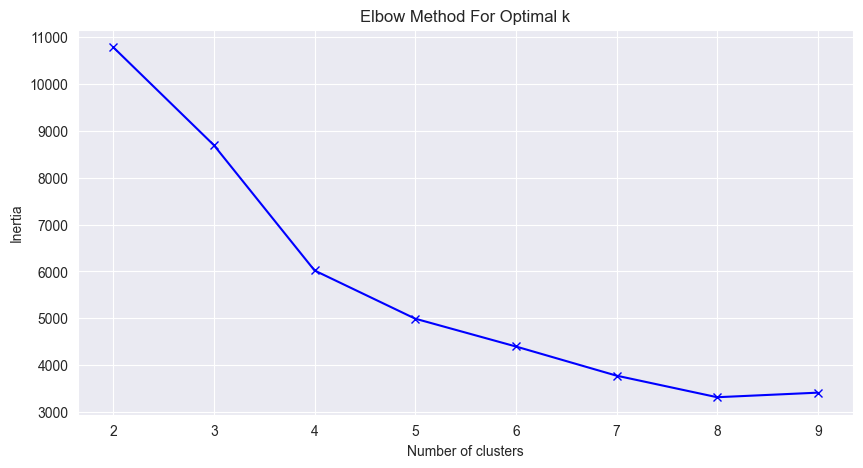

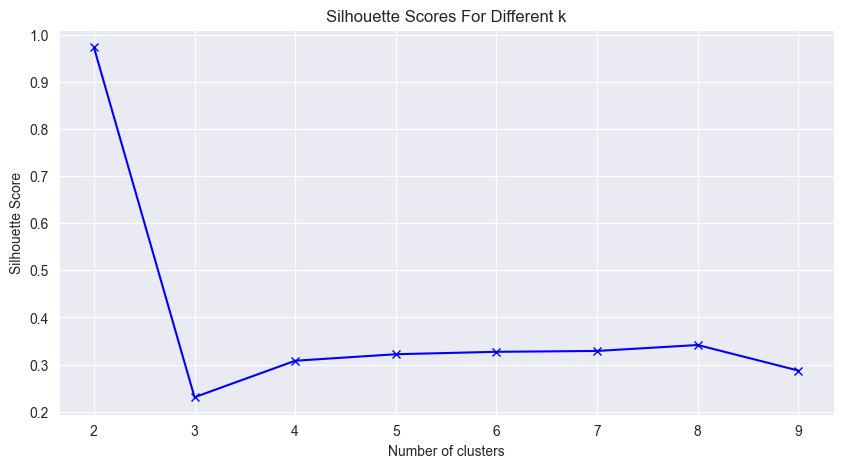

In [11]:
inertia = []
silhouette_scores = []
K = range(2, 10)

for k in K:
    kmeans = KMeans(n_clusters=k)
    kmeans.fit(scaled_features)
    inertia.append(kmeans.inertia_)

    # Calculate Silhouette Score
    score = silhouette_score(scaled_features, kmeans.labels_)
    silhouette_scores.append(score)

plt.figure(figsize=(10, 5))
plt.plot(K, inertia, "bx-")
plt.xlabel("Number of clusters")
plt.ylabel("Inertia")
plt.title("Elbow Method For Optimal k")
plt.show()

plt.figure(figsize=(10, 5))
plt.plot(K, silhouette_scores, "bx-")
plt.xlabel("Number of clusters")
plt.ylabel("Silhouette Score")
plt.title("Silhouette Scores For Different k")
plt.show()

## Apply Clustering with the Optimal Number of Clusters

In [12]:
optimal_clusters = 4  # visual assessment

kmeans = KMeans(n_clusters=optimal_clusters, random_state=42)
df["Cluster"] = kmeans.fit_predict(scaled_features)

silhouette_vals = silhouette_samples(scaled_features, df["Cluster"])
df["Silhouette Value"] = silhouette_vals


## Silhouette plot

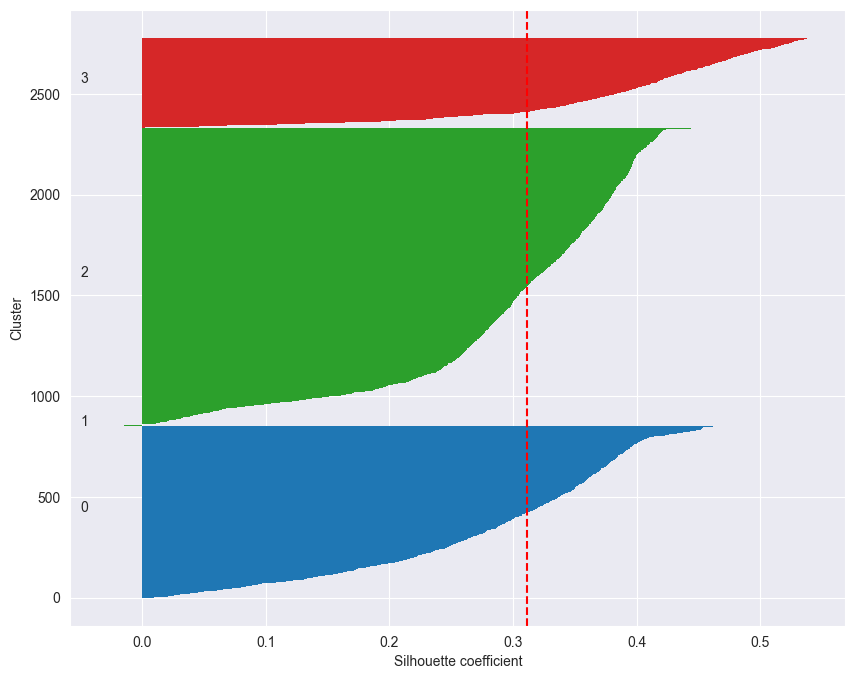

In [13]:
plt.figure(figsize=(10, 8))
y_lower, y_upper = 0, 0
for i in range(optimal_clusters):
    cluster_silhouette_vals = silhouette_vals[df["Cluster"] == i]
    cluster_silhouette_vals.sort()
    y_upper += len(cluster_silhouette_vals)
    plt.barh(
        range(y_lower, y_upper), cluster_silhouette_vals, edgecolor="none", height=1
    )
    plt.text(-0.05, (y_lower + y_upper) / 2, str(i))
    y_lower = y_upper

plt.xlabel("Silhouette coefficient")
plt.ylabel("Cluster")
plt.axvline(silhouette_vals.mean(), color="red", linestyle="--")
plt.show()

## Analyze the Clusters

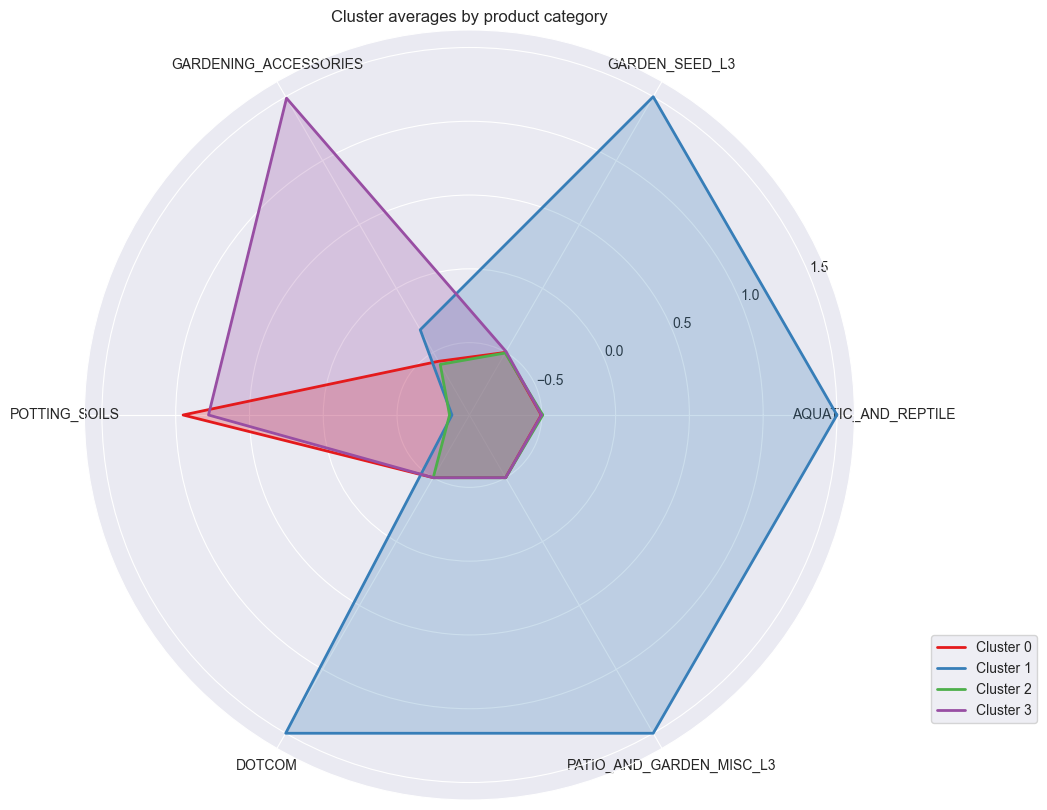

In [14]:
centroids = df.groupby("Cluster").mean().drop("store_id", axis=1).drop("Silhouette Value", axis=1)
centroids
centroids_normalized = (centroids - centroids.mean()) / centroids.std()
centroids_normalized
n_clusters = centroids_normalized.shape[0]
n_features = centroids_normalized.shape[1]
colors = sns.color_palette("Set1", n_clusters)

fig, ax = plt.subplots(figsize=(10, 10), subplot_kw=dict(polar=True))

labels = centroids_normalized.columns
angles = np.linspace(0, 2 * np.pi, n_features, endpoint=False).tolist()
angles += angles[:1]

for i in range(n_clusters):
    values = centroids_normalized.loc[i].values.tolist()
    values += values[:1]
    ax.fill(angles, values, color=colors[i], alpha=0.25)
    ax.plot(angles, values, color=colors[i], linewidth=2, label=f"Cluster {i}")

ax.set_xticks(angles[:-1])
ax.set_xticklabels(labels)

plt.title("Cluster averages by product category")
plt.legend(loc=(1.1, 0.1))

plt.show()

## Reduce the Dimensionality of the Data using t-SNE

t - SNE is a dimensionality reduction technique that is particularly well - suited for the visualization of high-dimensional datasets.It reduces the dimensionality of the data while preserving the relationships between the data points as much as possible.

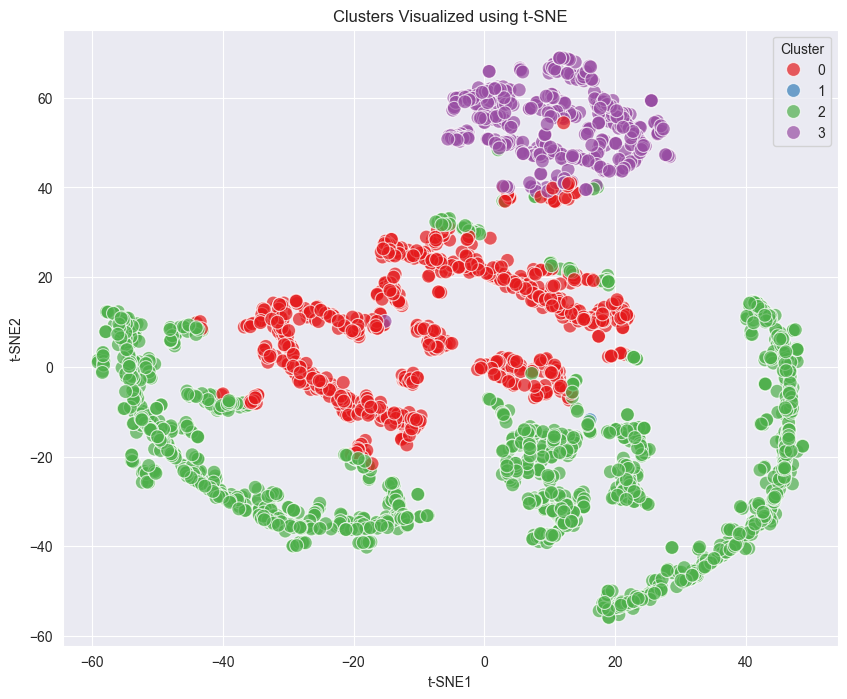

In [15]:
tsne = TSNE(n_components=2, random_state=42)
tsne_features = tsne.fit_transform(scaled_features)
df["t-SNE1"] = tsne_features[:, 0]
df["t-SNE2"] = tsne_features[:, 1]

plt.figure(figsize=(10, 8))
sns.scatterplot(
    x="t-SNE1", y="t-SNE2", hue="Cluster", data=df, palette="Set1", s=100, alpha=0.7
)
plt.title("Clusters Visualized using t-SNE")
plt.show()

## Describe the Clusters

In [16]:
openai = OpenAI()

centroids_content = "\n\n".join(
    centroids_normalized.apply(
        lambda x: ", ".join(x.index + " " + x.round(2).astype(str)), axis=1
    )
)

messages = [
    {
        "role": "system",
        "content": "You are an assistant helping describe product clusters based on their centroids."
                   "Create a SHORT synthetic description of each cluster."
                   "Separate each cluster description with a new line."
                   "Start with: "
                   "Cluster 0 can be called ... and represents...",
    },
    {"role": "user", "content": centroids_content},
]

response = openai.chat.completions.create(model="gpt-4o", messages=messages)

print(response.choices[0].message.content)

Cluster 0 can be called "Premium Potting Enthusiasts" and represents customers who primarily purchase potting soils with minimal interest in other gardening or aquatic products.

Cluster 1 can be called "Comprehensive Gardeners" and represents customers with a significant interest in aquatic and reptile products, garden seeds, and a broad range of patio and garden miscellaneous items, including strong online shopping habits.

Cluster 2 can be called "Low-Engagement Gardeners" and represents customers who show low purchasing activity across all categories, including aquatic, garden seeds, gardening accessories, and potting soils.

Cluster 3 can be called "Accessory-Focused Gardeners" and represents customers who have a strong preference for gardening accessories and moderate interest in potting soils, with low engagement in other product categories.


## Geographical distribution of clusters

In [ ]:
%%load store_df
SELECT
    store_id,
    store_longitude,
    store_latitude
FROM
    `{project}`.`{dataset}`.`{dim_store}`

In [62]:
store_df = store_df.merge(df, on="store_id").dropna()
center_lat = store_df["store_latitude"].mean()
center_lon = store_df["store_longitude"].mean()

m = folium.Map(location=[center_lat, center_lon], zoom_start=6)

colors = {0: "blue", 1: "green", 2: "red", 3: "purple"}

for _, row in store_df.iterrows():
    folium.Marker(
        location=[row["store_latitude"], row["store_longitude"]],
        popup=f"Store ID: {row['store_id']}",
        icon=folium.Icon(color=colors[row["Cluster"]]),
    ).add_to(m)

# Add legend
legend_html = """
<div style="position: fixed;
        bottom: 20px; left: 20px; width: 90px; height: 140px;
        border:2px solid grey; z-index:9999; font-size:14px;
        background-color: white;
        opacity: 0.8;
        ">
        <p style="margin: 10px"> <span style="color:blue">Cluster 0</span></p>
        <p style="margin: 10px"> <span style="color:green">Cluster 1</span></p>
        <p style="margin: 10px"> <span style="color:red">Cluster 2</span></p>
        <p style="margin: 10px"> <span style="color:purple">Cluster 3</span></p>
</div>
"""
m.get_root().html.add_child(folium.Element(legend_html))

m